## Udacity Self-Driving Car Engineer Nanodegree Program
### Project 5 -- Vehicle Detection Project

The goals/steps of this project are the following:
* perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your piprline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to rehect outliers and follow detected vehicles.
* Estimate a bounding bos for vehicles detected.

In [13]:
# Import all the python packages and functions we need for this project.
import matplotlib.image as mpimg
import  matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import numpy as np
import pickle 
import cv2
import glob
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

print ('Import done!')

Import done!


#### Download the training dataset and load them

In [14]:
car_images = glob.glob('./vehicles/**/*.png')
noncar_images = glob.glob('./non-vehicles/**/*.png')

print('The number of car image is {},and number of non-car images is {}'.format(len(car_images),len(noncar_images)))

The number of car image is 8792,and number of non-car images is 8968


#### Visualize the dataset in some extent

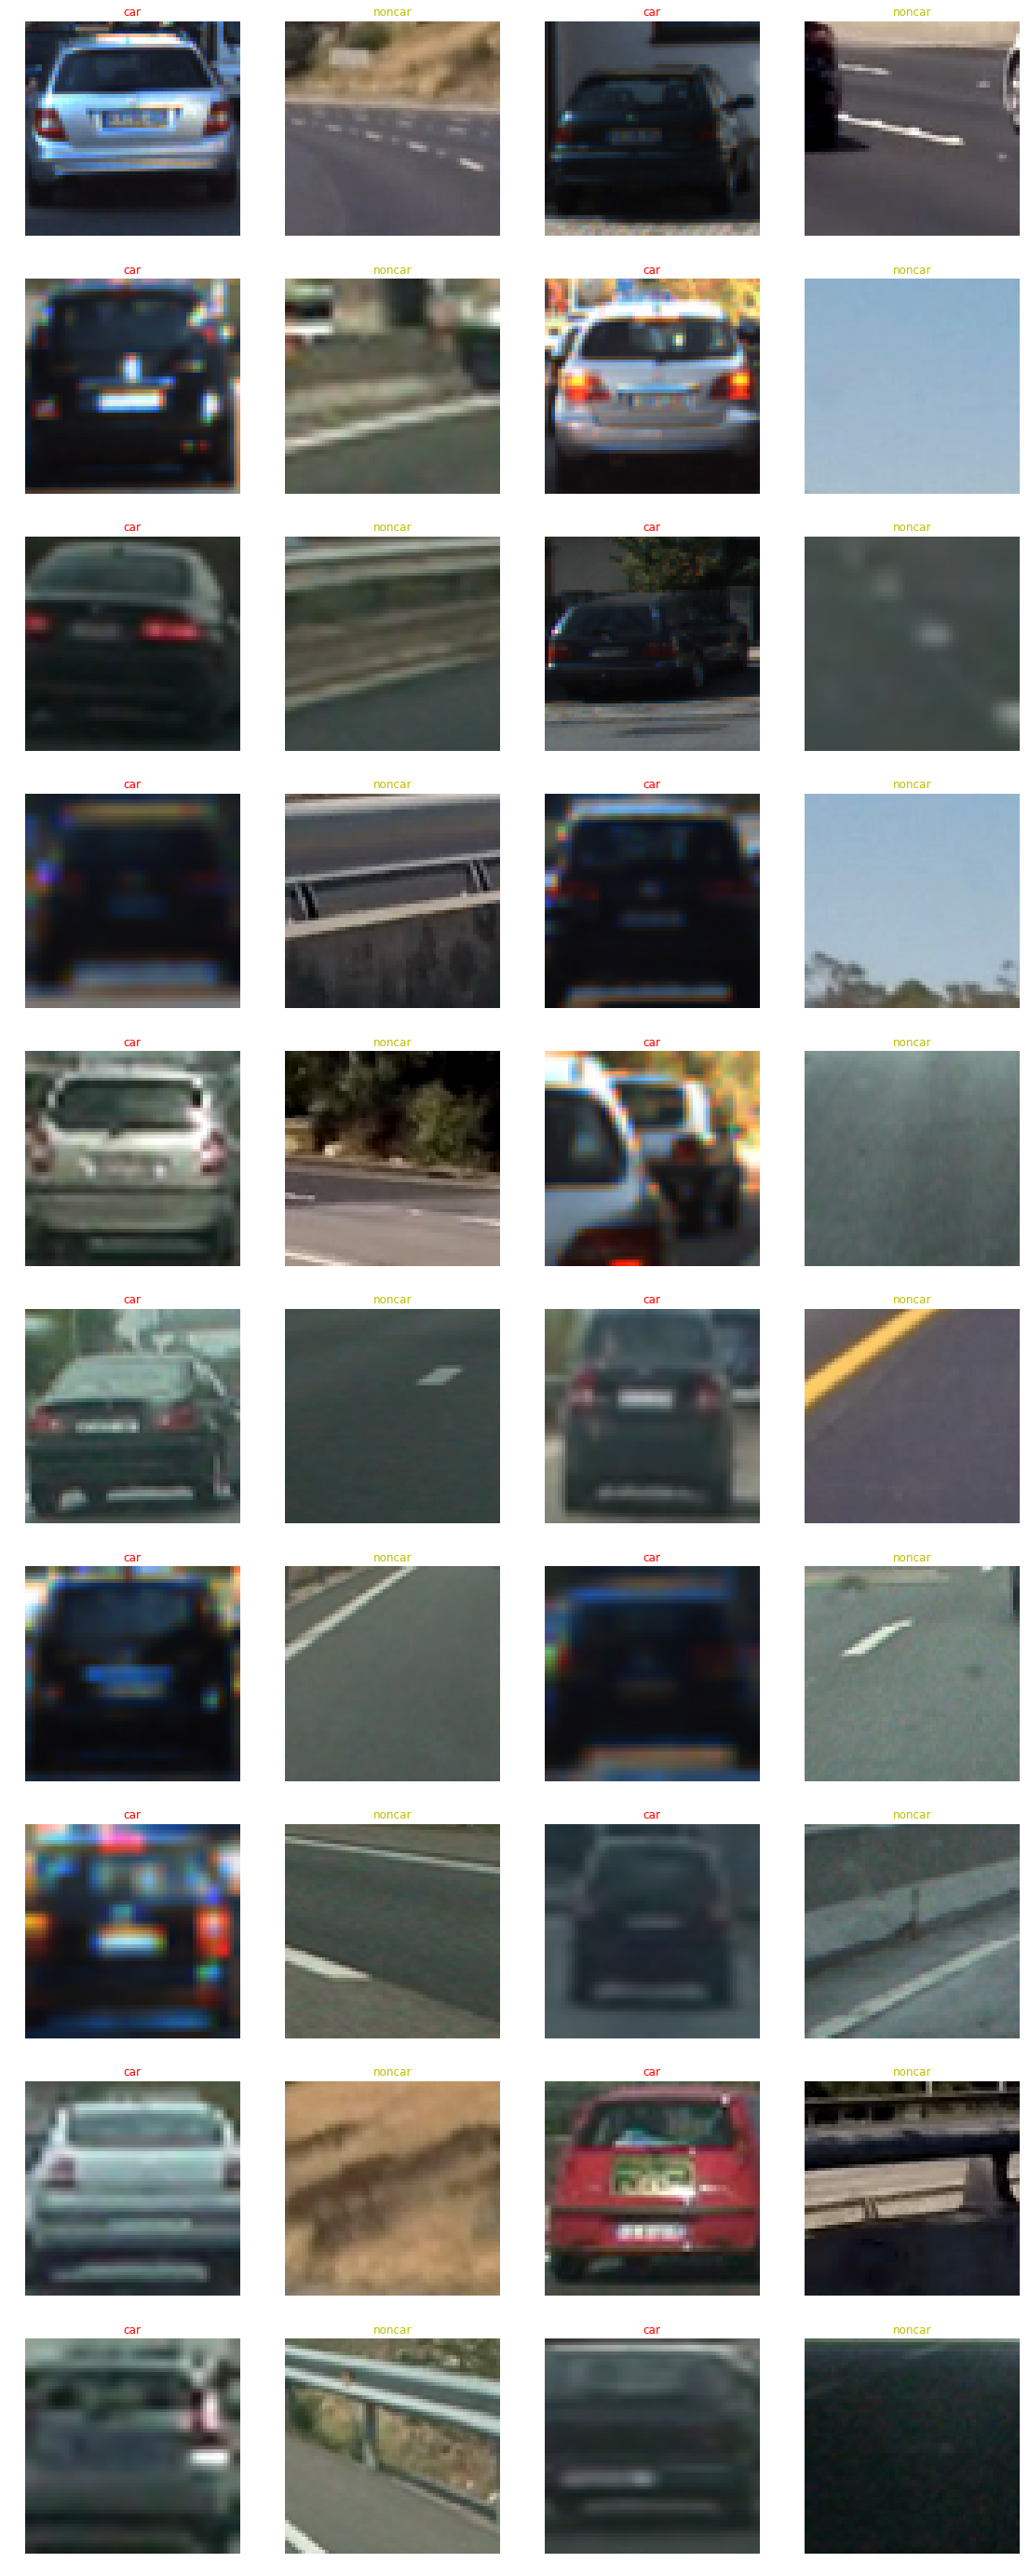

In [15]:
fig,axes = plt.subplots(10,4,figsize = (20,50))
fig.subplots_adjust(hspace=.2,wspace=.002)
axes = axes.ravel()
# Plot the car and non-car dataset for visualization
for i in range(40):
    #img_car = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
    # img_noncar = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img_car = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img_noncar = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img_car = cv2.cvtColor(img_car,cv2.COLOR_BGR2RGB)
    img_noncar = cv2.cvtColor(img_noncar,cv2.COLOR_BGR2RGB)
    
    if i % 2 == 0:
        axes[i].imshow(img_car)
        axes[i].set_title('car',fontsize=12,color='r')
        axes[i].axis('off')
    
    else:
        axes[i].imshow(img_noncar)
        axes[i].set_title('noncar',fontsize=12,color='y')
        axes[i].axis('off')

From the above results, we can see that in the first and third column the images are all cars, however the second and forth columns are all non-cars, moreover the number of the car and  non car are almost the same for the training dataset, which is 8792 and 8968 respectively.

#### Define the HOG function 

In [16]:
# We'll still use the same one from the online course materials
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    # Call with two outputs if vis == True
    if vis == True:
        features, hog_image = hog(img,orientations=orient,pixels_per_cell = (pix_per_cell,pix_per_cell),cells_per_block=(cell_per_block,cell_per_block),transform_sqrt=False,visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    # otherwise call with one output
    else:
        features = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),cells_per_block = (cell_per_block,cell_per_block),transform_sqrt= False,visualise=vis,feature_vector=feature_vec)
        return features

print("HOG function Done!")
    


HOG function Done!


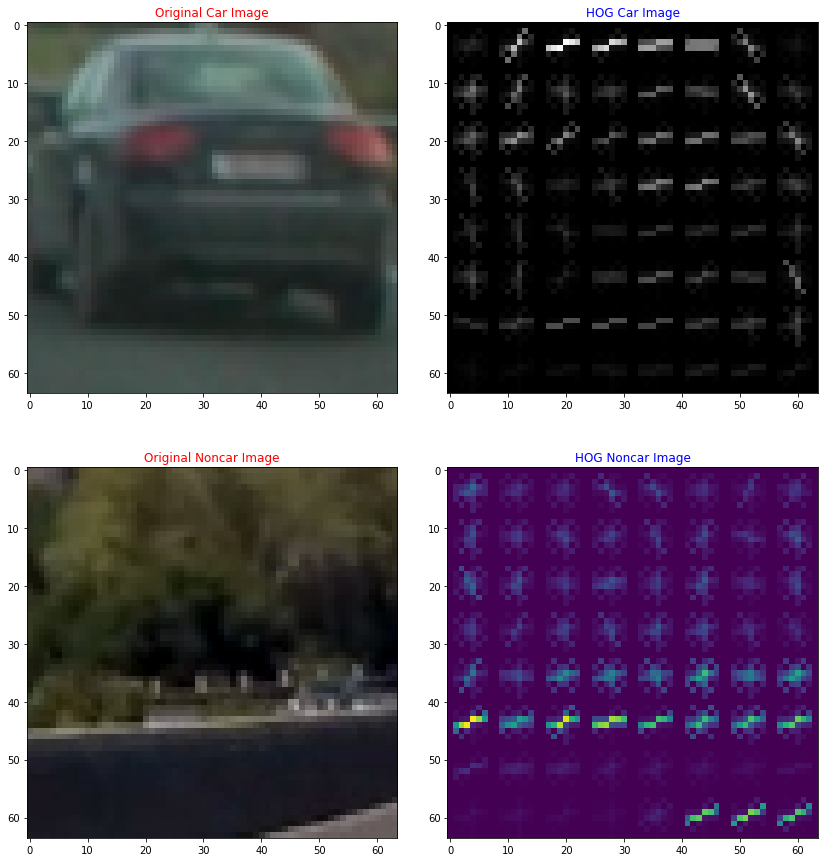

In [17]:
# test the HOG function with some images
car_img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
_,car_dst = get_hog_features(car_img[:,:,2],9,8,8,vis=True,feature_vec=True)

noncar_img = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
_,noncar_dst = get_hog_features(noncar_img[:,:,2],9,8,8,vis=True,feature_vec=True)

# Visualization for the results of the HOG funtion for the different images
fig,axes = plt.subplots(2,2,figsize=(15,15))
fig.subplots_adjust(hspace=0.2,wspace=0.01)

axes = axes.ravel()

axes[0].imshow(car_img)
axes[0].set_title('Original Car Image',fontsize = 12,color='r')

axes[1].imshow(car_dst,cmap='gray')
axes[1].set_title('HOG Car Image',fontsize=12,color='b')

axes[2].imshow(noncar_img,cmap='gray')
axes[2].set_title('Original Noncar Image',fontsize=12,color='r')

axes[3].imshow(noncar_dst)
axes[3].set_title('HOG Noncar Image',fontsize=12,color='b')



In [18]:
# Extract the HOG features from the list of images
# This function could also be usedto call bin_spatial() and color_hist() to extract flattened spatial color features
# and color histogram features and combine them all to be used together for classification

def extract_features(imgs,cspace='RGB',orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0):
    
    # Create a list to append feature vectors 
    features = []
    
    # iterate through the list of images
    for img_name in imgs:
        # read in each one by one
        image = mpimg.imread(img_name)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
            
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=Fasle,feature_vec=True)
        
        features.append(hog_features)
    
    return features

print('Extract HOG features Function Done!')

Extract HOG features Function Done!


#### Test the extract feature funtions with the images


In [20]:
# The parameters for feature extraction 
colorspace = 'YUV' # can be RGB,HSV,LUV,HLS,ETC
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # can be 0,1,2,all

t1 = time.time()
car_features = extract_features(car_images,cspace=colorspace,orient=orient,pix_per_cell = pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel)

notcar_features = extract_features(noncar_images,cspace=colorspace,orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel)

t2 = time.time()
print('The features extraction has consumed about {} seconds'.format(round(t2-t1,2)))


# Create an array stack of feature vectors
x = np.vstack((car_features,notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))


# split up date into randomized training and test sets
rand_state = np.random.randint(0,100)

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=rand_state)

print('Feature length:',len(X_train[0]))



The features extraction has consumed about 47.36 seconds
Feature length: 1188


#### Train a classifier baed on this feature extractor

In [21]:
# Use a linear SVC from sklearn
svc = LinearSVC()

t1 = time.time()
svc.fit(X_train,y_train)
t2 = time.time()
print('Training SVC consumes {} seconds'.format(round(t2-t1,2)))

# Check the score of the SVC
svc_score = svc.score(X_test,y_test)
print('Test Accuracy of SVC = ',round(svc_score,4))


Training SVC consumes 0.97 seconds
Test Accuracy of SVC =  0.9811


#### Method for Using classifier to detect cars in an image

In [22]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            hog_features = hog_features.ravel().reshape(1,-1)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('...')

...


#### Method to draw retangles onto images
Get it from the materials

In [23]:
# Define the draw function onto an image
def draw_boxes(img,bboxes,color=(0,0,255),thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    random_color = False
    # Draw all the boxes from the list onto the image
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img,bbox[0],bbox[1],color,thick)
    return draw_img
print('Draw rectangle function done!')

Draw rectangle function done!


Done!


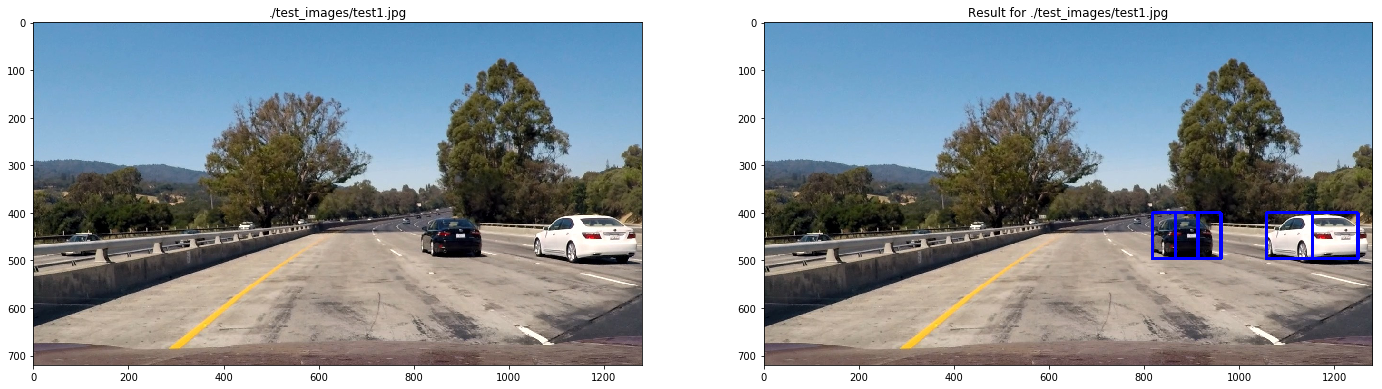

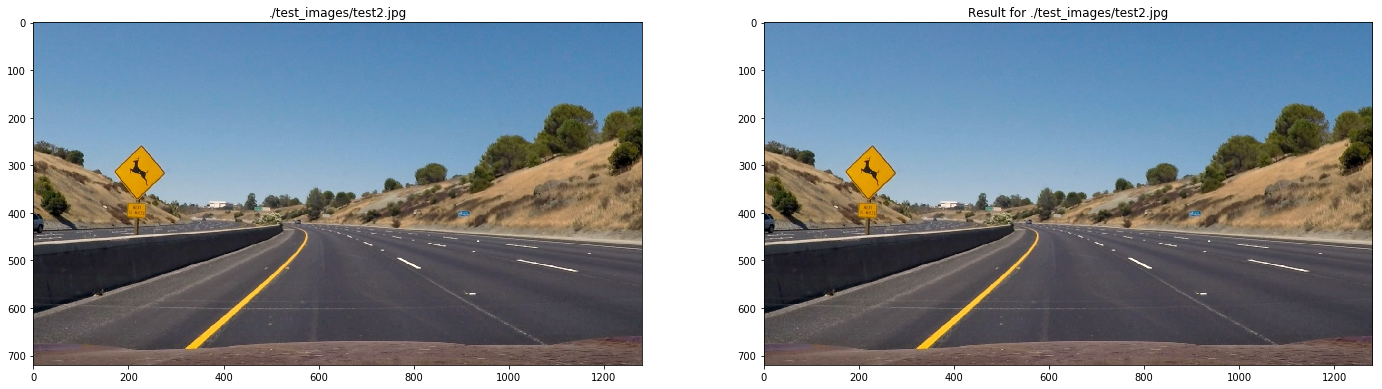

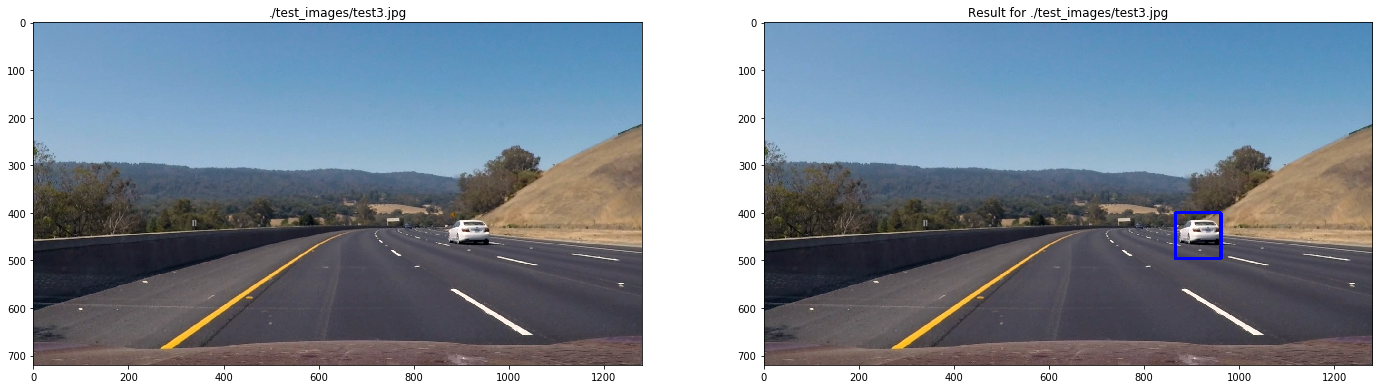

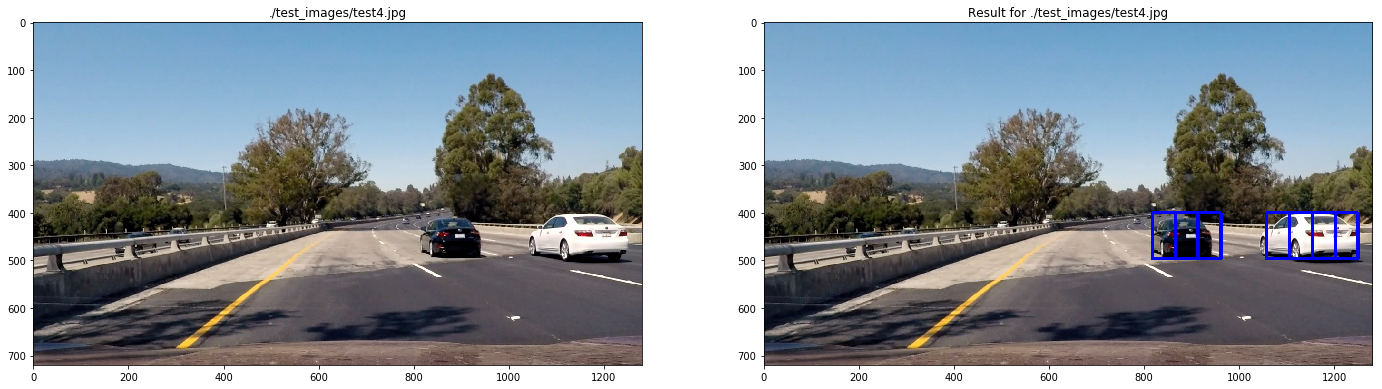

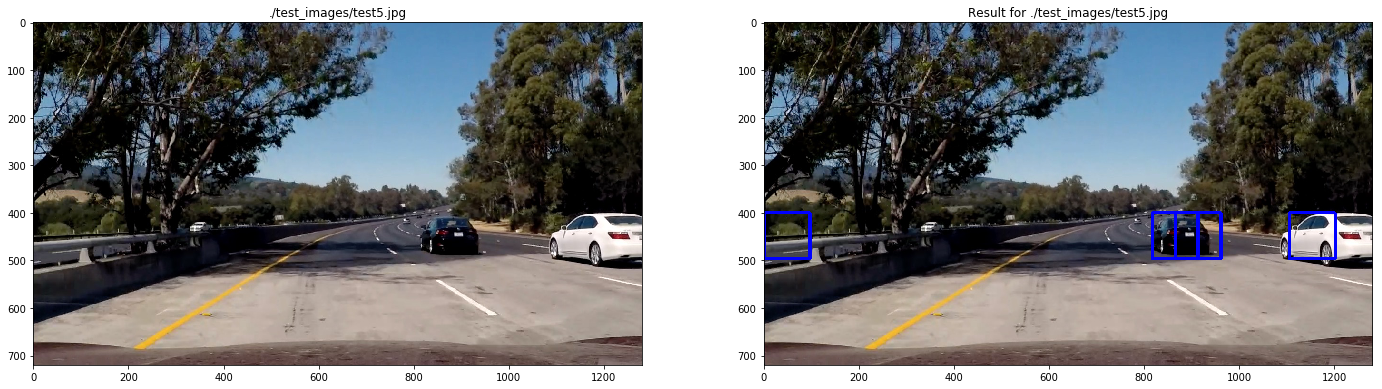

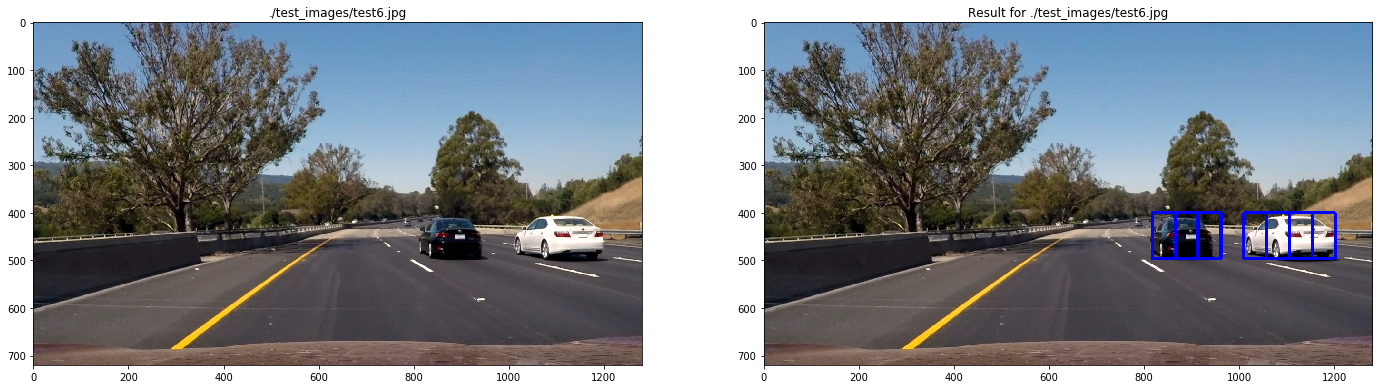

In [24]:
# Test the functions with an example image
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

for i in range(6):
    img_name = './test_images/test{}.jpg'.format(i+1)
    test_img = mpimg.imread(img_name)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    
    rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)
    test_img_rects = draw_boxes(test_img,rectangles)
    ax1.imshow(test_img)
    ax1.set_title(img_name)
    ax2.imshow(test_img_rects)
    ax2.set_title('Result for {}'.format(img_name))

   

print('Done!')

Since the size and position of cars in the images will be different, so we need to tune the parameters to make it more robust for the detection of cars with different size and positions.

Done with various of parameters considering the sizes and positions of the cars in the image!


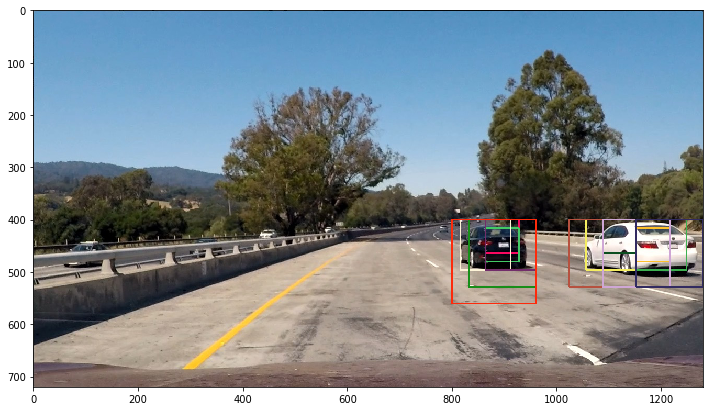

In [137]:
# find the cars more robustly for their sizes and positions
def Parameter(increasement_ystart,increasement_ystop,increasement_scale):
    y_start = 400
    y_stop = 464
    scale = 1.0
    y_start_increased = y_start + increasement_ystart
    y_stop_increased = y_stop + increasement_ystop
    scale_increased = scale + increasement_scale
    return y_start_increased,y_stop_increased,scale_increased

test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YUV' 
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

# Get the first set of parameters considering the size and positions of the cars
ystart,ystop,scale = Parameter(0,0,0)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))
# Get the second set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(16,16,0)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the third set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(0,32,0.5)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the sforth set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(32,64,0.5)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the fifth set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(0,64,1.0)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the sixth set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(32,96,1.0)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the seventh set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(0,96,2.5)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the eighth set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(64,160,2.5)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the ninth set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(16,80,2.5)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the tenth set of parameters considering the size and positions of the cars in the test image
ystart,ystop,scale = Parameter(64,128,2.5)
rectangles.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the ninth set of parameters considering the size and positions of the cars in the test image

ystart,ystop,scale = Parameter(16,80,1.5)

rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


# Get the tenth set of parameters considering the size and positions of the cars in the test image

ystart,ystop,scale = Parameter(64,128,1.5)

rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

# Get the 11th set of parameters considering the size and positions of the cars in the test image

ystart,ystop,scale = Parameter(0,128,1.5)

rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))
    
# Get the tenth set of parameters considering the size and positions of the cars in the test image

ystart,ystop,scale = Parameter(32,160,1.5)

rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


rectangles = [item for sublist in rectangles for item in sublist]
#rectangles = np.ravel(rectangles)
test_img_draw = draw_boxes(test_img,rectangles,color='random',thick=2)
plt.figure(figsize=(12,12))
plt.imshow(test_img_draw)

print('Done with various of parameters considering the sizes and positions of the cars in the image!')


#### Heatmap 
This method is mentioned in the online course in order to reduce the false positive and multiple detections for one car.

In [138]:
def heat_map(img,bbox_list):
    # Create the heatmap
    heatmap = np.zeros_like(img[:,:,0])
    # Iterate through list of the bboxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heatmap
print('Done with the add_heat function!')
        

Done with the add_heat function!


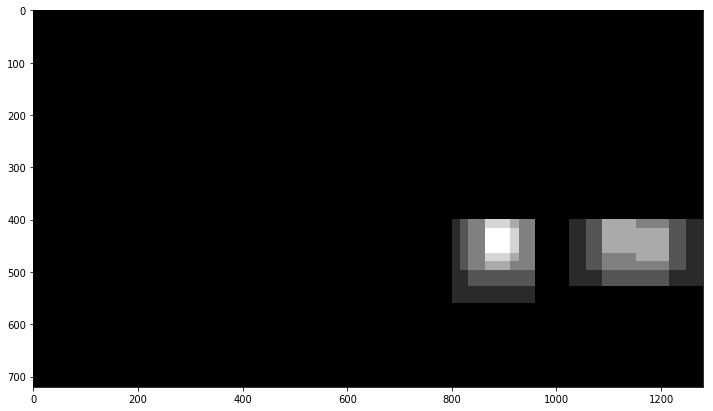

In [139]:
heatmap = heat_map(test_img,rectangles)
plt.figure(figsize=(12,12))
plt.imshow(heatmap,cmap='gray')

#### Apply a threshold to the Heatmap
The threshold function is aiming to eliminate the false positive in case.

In [140]:
def apply_threshold(heatmap,threshold):
    heatmap[heatmap<= threshold] = 0
    return heatmap

print('Done with applying threshold for the heatmap!')

Done with applying threshold for the heatmap!


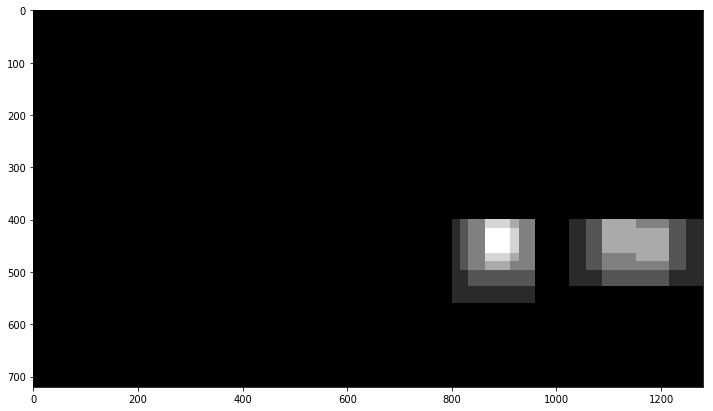

In [141]:
heatmap_img = apply_threshold(heatmap,0.8)
plt.figure(figsize=(12,12))
plt.imshow(heatmap_img,cmap='gray')

#### Apply Scipy labels to Heatmap

2 car found


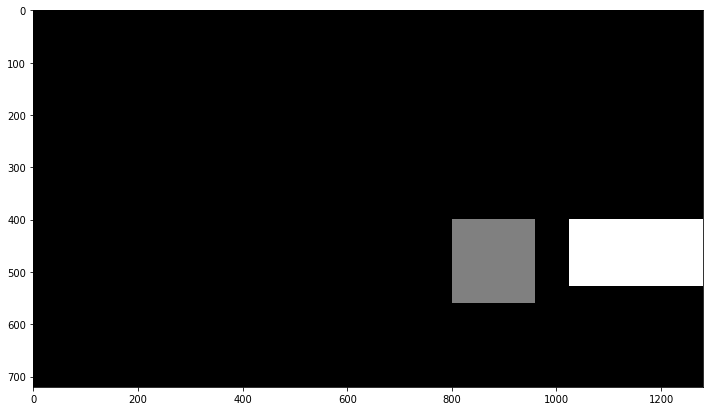

In [142]:
labels = label(heatmap_img)
plt.figure(figsize=(12,12))
plt.imshow(labels[0],cmap='gray')
print(labels[1],'car found')

#### Draw boxed for the labels

In [143]:
def draw_labeled_bboxes(img,labels):
    rects = []
    for car_number in range(1,labels[1] +1):
        # Find the pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # identify the x and y coordinates for pixels where there is a car label
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define the bboxes for the car labels
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        rects.append(bbox)
    
        # Draw the box on the image
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),4)
    return img,rects

print('Done with the draw boxes for the car labels!')

Done with the draw boxes for the car labels!


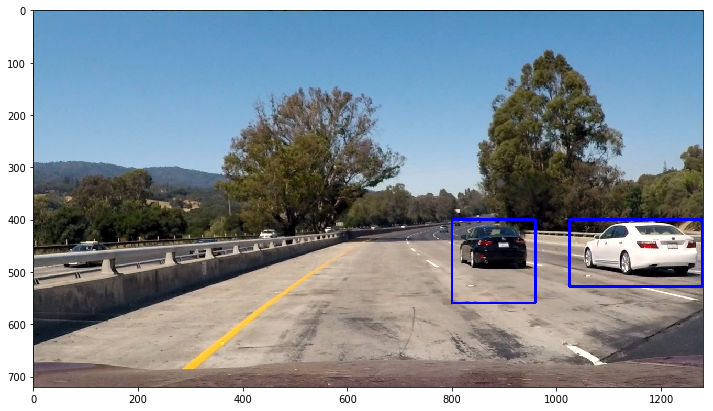

In [144]:
# Draw the box for the labels in the img
draw_img,rect = draw_labeled_bboxes(np.copy(test_img),labels)
plt.figure(figsize=(12,12))
plt.imshow(draw_img)

#### The pipeline for all these functions

In [145]:
def pipeline_car(img):
    # Create the list to store the bboxes
    rectangles = []
    

    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'
    # Get the first set of parameters considering the size and positions of the cars
    ystart,ystop,scale = Parameter(0,0,0)
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))
    # Get the second set of parameters considering the size and positions of the cars in the test image
    ystart,ystop,scale = Parameter(16,16,0)
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the third set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,32,0.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


    # Get the sforth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(32,64,0.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


    # Get the fifth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,64,1.0)
    
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the sixth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(32,96,1.0)
    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the seventh set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,96,2.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the eighth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(64,160,2.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the ninth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(16,80,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))


    # Get the tenth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(64,128,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))

    # Get the 11th set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(0,128,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))
    
    # Get the tenth set of parameters considering the size and positions of the cars in the test image

    ystart,ystop,scale = Parameter(32,160,1.5)

    rectangles.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,None,orient,pix_per_cell,cell_per_block,None,None))



    rectangles = [item for sublist in rectangles for item in sublist]
    

    heatmap_img = heat_map(img,rectangles)

    heatmap_img = apply_threshold(heatmap_img,threshold = 1)

    labels = label(heatmap_img)

    draw_img,rects = draw_labeled_bboxes(np.copy(img),labels)
    

    return draw_img
print ('Done with the Pipeline!')

Done with the Pipeline!


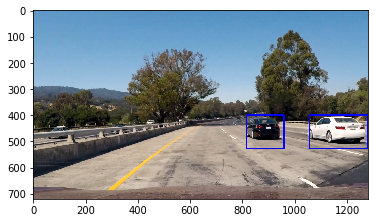

In [146]:
img = pipeline_car(test_img)
plt.imshow(img)

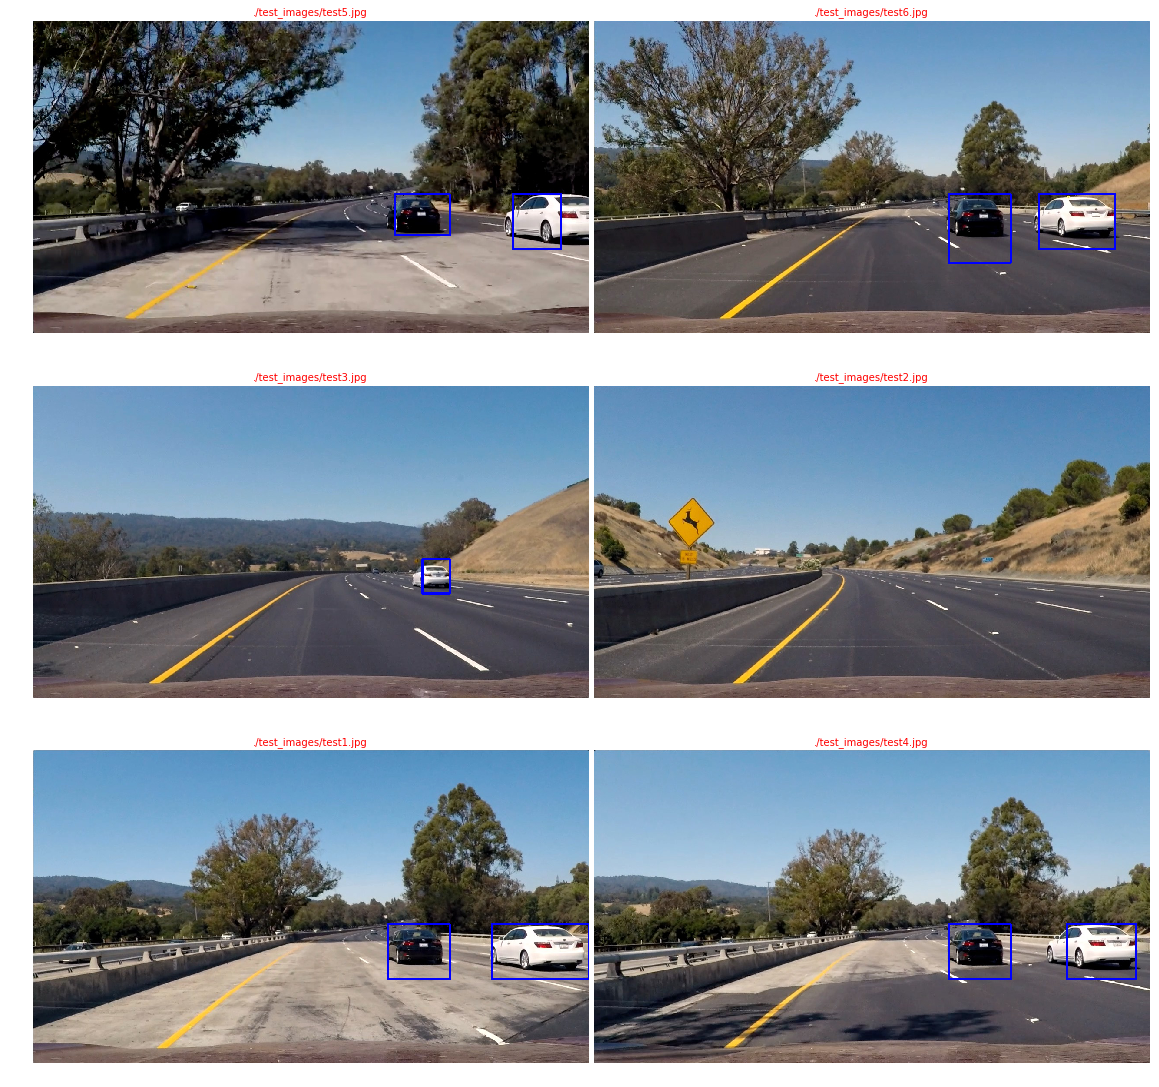

In [147]:
# Run this pipeline with the test_images
images = glob.glob('./test_images/test*.jpg')

fig,axs = plt.subplots(3,2,figsize=(20,20))
fig.subplots_adjust(hspace=0.02,wspace=0.01)
axs = axs.ravel()

for i,img_name in enumerate(images):
    img = mpimg.imread(img_name)
    axs[i].imshow(pipeline_car(img))
    axs[i].set_title(img_name,fontsize=10,color='red')
    axs[i].axis('off')

#### Run a video Through the pipeline

In [148]:
Test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_car)
% time clip_test_out.write_videofile(Test_out_file,audio=False)

HTML("""
<video width="960" height='540' controls>
    <source src='{0}'>
</video>""".format(Test_out_file))

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 52.7 s, sys: 92 ms, total: 52.8 s
Wall time: 13.2 s


In [149]:
Test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline_car)
% time clip_test_out.write_videofile(Test_out_file,audio=False)

HTML("""
<video width="960" height='540' controls>
    <source src='{0}'>
</video>""".format(Test_out_file))

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [06:48<00:00,  3.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 28min 51s, sys: 3.08 s, total: 28min 54s
Wall time: 6min 49s


#### Apply this pipeline on the Advanced Lane Line detection output video.

In [150]:

Test_out_file = 'project_video_out2.mp4'
clip_test = VideoFileClip('project_video_output.mp4')
clip_test_out = clip_test.fl_image(pipeline_car)
% time clip_test_out.write_videofile(Test_out_file,audio=False)

HTML("""
<video width="960" height='540' controls>
    <source src='{0}'>
</video>""".format(Test_out_file))

[MoviePy] >>>> Building video project_video_out2.mp4
[MoviePy] Writing video project_video_out2.mp4


100%|█████████▉| 1260/1261 [06:48<00:00,  3.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out2.mp4 

CPU times: user 28min 44s, sys: 3.07 s, total: 28min 47s
Wall time: 6min 48s


From the above results, we can see the boxes for the car labeled in each image is not very good (see the first video white car only about half of its shape is boxed), sometimes just circle about 50% of the car itself, we could improve this performance with more Parameter selection options to get more overlap sections in the image for the car in order to improve the circle accuracy.